## The Forecasting Tool-kit

Statistical forecasting algorithms like ARIMA and ETS have been the champions in the field of time series forecasting. Libraries like pmdarima and statsforecast have performed quite well in various practical and industrial use cases. However, new and advanced machine learning models are taking the stage due to their ability to learn complex patterns from the raw data. Let’s briefly observe the differences between these algorithms.

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/python/TS/one.png" width="900"  alt="image">

### Let’s Ensemble!
The machine learning models that we are going to explore in this study are based on the ensemble principle. Ensemble models are a machine learning approach to combine multiple other models in the forecasting process. These models are referred to as base estimators. Thus, in place of an individual model, the ensemble models use a collection of models for making forecasts.

Ensemble uses two methods:

 **Bagging:** It creates a different training subset from sample training data with replacement and the final output is based on majority voting, e,g., Random Forest.

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/python/TS/two.png" width="600"  alt="image">

**Boosting:** It combines the weak learners into strong learners by creating a sequential models such that the final model has the highest accuracy.
e.g., LGBM, XGB etc.

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/python/TS/three.png" width="600"  alt="image">

The StatsForecast and MLForecast packages used in this study are designed by the NIXTLA team.
Further details about them can be found [here](https://www.nixtla.io/)

In [1]:
!pip install statsforecast -q
!pip install mlforecast -q
!pip install pmdarima -q
!pip install window-ops -q
#!pip install prophet -q #already installed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.8 MB/s eta 0:00:00


In [2]:
#!wget https://frenzy86.s3.eu-west-2.amazonaws.com/timeseries/Data/airline_passengers.csv
path="https://frenzy86.s3.eu-west-2.amazonaws.com/timeseries/Data/airline_passengers.csv"

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsforecast import StatsForecast
from pmdarima import auto_arima
from statsforecast.models import AutoARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
df = pd.read_csv(path)
df['Month'] = pd.to_datetime(df['Month'])

df = df.set_index('Month').resample('MS').mean()
df = df.interpolate() #to interpolate and fill missing values
df.columns = ['#Passengers']
df

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


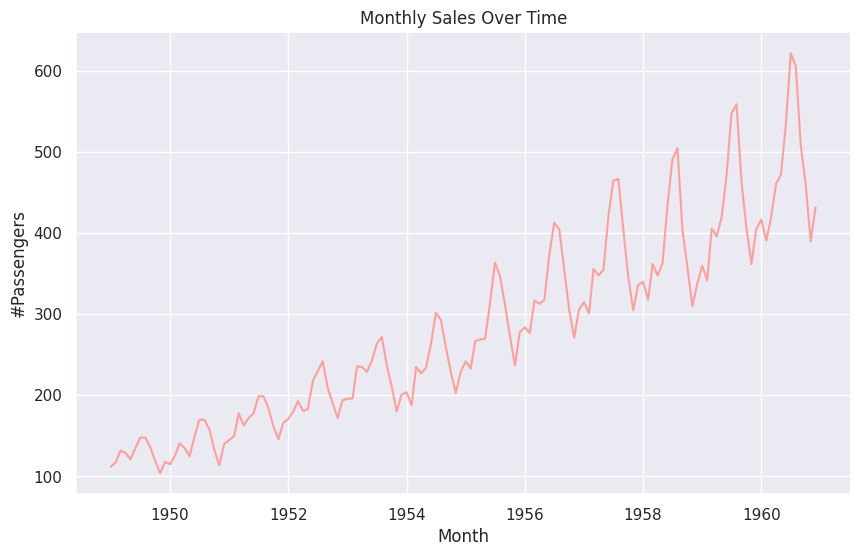

In [5]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="Month", y='#Passengers', data=df, color='#ff9f9b')
plt.title('Monthly Sales Over Time')
plt.xlabel('Month')
plt.ylabel('#Passengers')
plt.show()

### seasonal decomposition

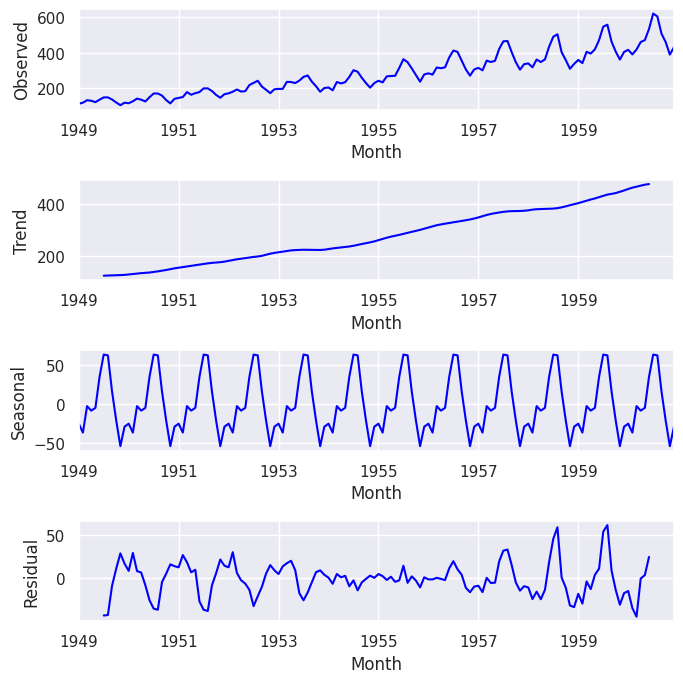

In [6]:
result = seasonal_decompose(df['#Passengers'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(7, 7))

result.observed.plot(ax=ax1, color="blue")
ax1.set_ylabel('Observed')

result.trend.plot(ax=ax2, color='blue')
ax2.set_ylabel('Trend')

result.seasonal.plot(ax=ax3, color='blue')
ax3.set_ylabel('Seasonal')

result.resid.plot(ax=ax4, color='blue')
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

### Model Building
Now let’s build the Statistical and Machine Learning Models.

In [7]:
#Train-Test Split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print(f'Train set size: {len(train)}')
print(f'Test set size: {len(test)}')

Train set size: 115
Test set size: 29


In [8]:
pmdarima_model = auto_arima(train['#Passengers'],
                            seasonal=True,
                            m=12,
                            )

pmdarima_forecast = pmdarima_model.predict(n_periods=len(test))
pmdarima_forecast_df = pd.DataFrame({'Date': test.index,
                                    'PMDARIMA_Forecast': pmdarima_forecast,
                                    })
#pmdarima_forecast_df

### Forecasting using Exponential Smoothening



In [9]:
ets_model = ExponentialSmoothing(train['#Passengers'],
                                seasonal='mul',
                                seasonal_periods=12,
                                ).fit()

ets_forecast = ets_model.forecast(steps=len(test))
ets_forecast_df = pd.DataFrame({'Date': test.index,
                                'ETS_Forecast': ets_forecast,
                                })

### Forecasting using Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwf0oknqy/78upkrlh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwf0oknqy/t4s61jm8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82375', 'data', 'file=/tmp/tmpwf0oknqy/78upkrlh.json', 'init=/tmp/tmpwf0oknqy/t4s61jm8.json', 'output', 'file=/tmp/tmpwf0oknqy/prophet_modelh9q8qfha/prophet_model-20250130060115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:01:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:01:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,Date,Pr_yhat,Pr_yhat_l,Pr_yhat_u
0,1958-08-01,482.246693,471.093491,492.455622
1,1958-09-01,426.221877,415.387649,437.147911
2,1958-10-01,370.337632,359.482511,381.243301
3,1958-11-01,322.553539,310.966288,333.136819
4,1958-12-01,365.967385,354.606563,377.409466


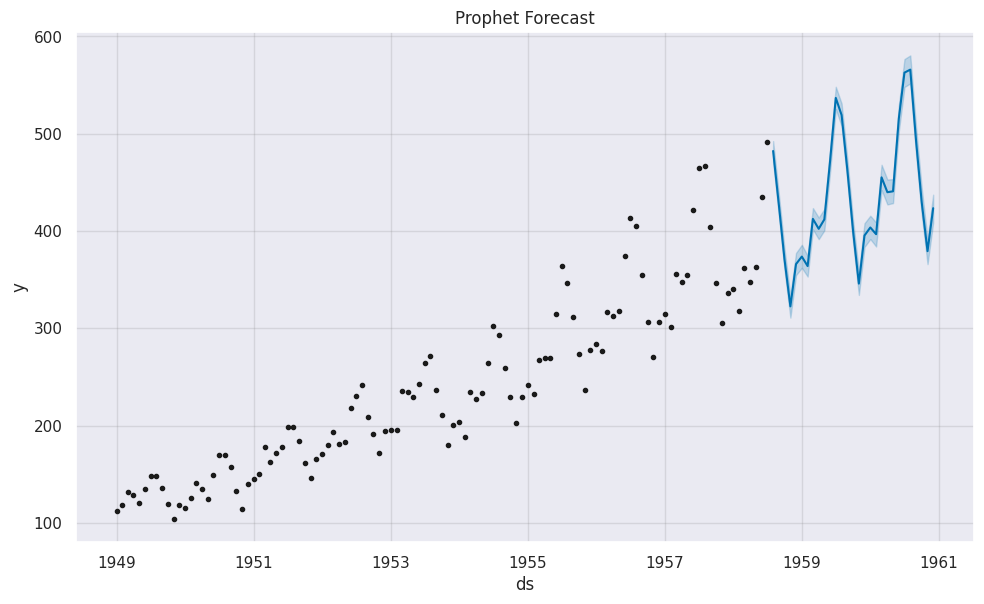

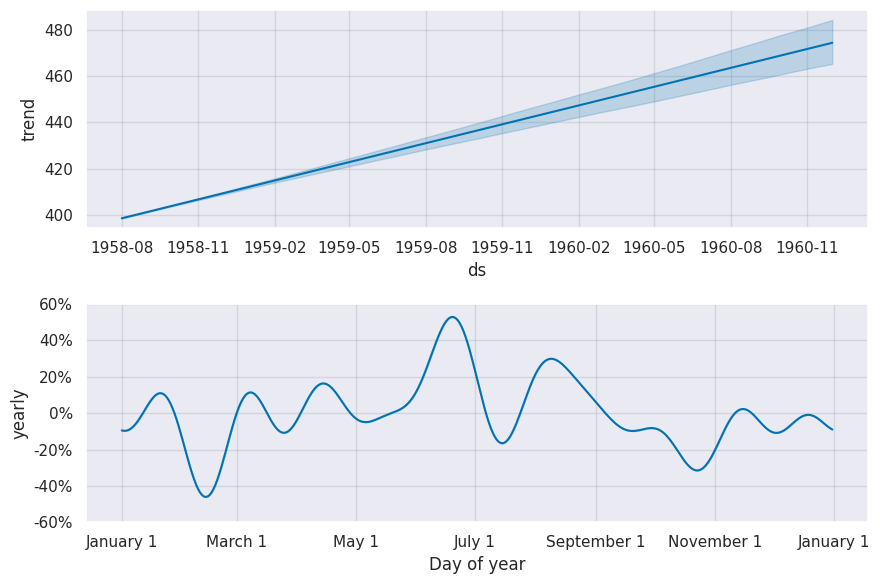

In [10]:
from prophet import Prophet

prophet_df = pd.DataFrame({
                            'ds': train.index,
                            'y': train['#Passengers']
                            })
prophet_model = Prophet(
                        yearly_seasonality=True,
                        weekly_seasonality=False,
                        daily_seasonality=False,
                        seasonality_mode='multiplicative'  # Usa modalità moltiplicativa come nell'ETS
                        )

prophet_model.fit(prophet_df)
future_dates = pd.DataFrame({'ds': test.index})
prophet_forecast = prophet_model.predict(future_dates)

prophet_forecast_df = pd.DataFrame({
                                    'Date': prophet_forecast['ds'],
                                    'Pr_yhat': prophet_forecast['yhat'],
                                    'Pr_yhat_l': prophet_forecast['yhat_lower'],
                                    'Pr_yhat_u': prophet_forecast['yhat_upper']
                                })


fig1 = prophet_model.plot(prophet_forecast)
plt.title('Prophet Forecast')
fig2 = prophet_model.plot_components(prophet_forecast)
prophet_forecast_df.head()

### Forecasting using StatsForecast Library



In [11]:
train_ = pd.DataFrame({'unique_id':[1]*len(train),
        'ds': train.index, "y":train['#Passengers']})

test_ = pd.DataFrame({'unique_id':[1]*len(test),
        'ds': test.index, "y":test['#Passengers']})

sf_forecast = StatsForecast(models = [AutoARIMA(season_length = 12)],freq = 'MS')

sf_forecast.fit(train_)
sf_prediction = sf_forecast.predict(h=len(test))
sf_prediction.rename(columns={'ds': 'Month'}, inplace=True)

Forecasting using MLForecast Library — Linear Regression, Random Forest Regression, Light GBM Regression and Extreme Gradient Boosting Regression.

In [12]:
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

models = [LinearRegression(),
          lgb.LGBMRegressor(verbosity=-1),
          xgb.XGBRegressor(),
          RandomForestRegressor(random_state=667),
          ]

fcst = MLForecast(
                models=models,
                freq='MS',  # Monthly frequency
                lags=[1, 3, 5, 7, 12],
                lag_transforms={
                    1: [ExpandingMean()],
                    3: [RollingMean(window_size=3), RollingMean(window_size=6)],
                    5: [RollingMean(window_size=3), RollingMean(window_size=6)],
                    7: [RollingMean(window_size=3), RollingMean(window_size=6)],
                    12: [RollingMean(window_size=3), RollingMean(window_size=6)],
                },
                date_features=['year', 'month', 'quarter'],  # Removed 'day' for monthly data
                target_transforms=[Differences([1])]
                )

fcst.fit(train_)

ml_prediction = fcst.predict(len(test_))
ml_prediction.rename(columns={'ds': 'Month'}, inplace=True)

### Performance Evaluation and Comparison
Now let’s combine the forecasts into a single dataframe and compare them based on accuracy metrices.

In [13]:
fcst_result = test.copy()
#fcst_result.set_index("Month", inplace=True)
fcst_result["AutoARIMA_fcst"]=sf_prediction["AutoARIMA"].values
fcst_result["PMDArima_fcst"]=pmdarima_forecast_df["PMDARIMA_Forecast"].values
fcst_result["ETS_fcst"]=ets_forecast_df["ETS_Forecast"].values
fcst_result["LinearRegression_fcst"]=ml_prediction["LinearRegression"].values
fcst_result["LGBM_fcst"]=ml_prediction["LGBMRegressor"].values
fcst_result["XGB_fcst"]=ml_prediction["XGBRegressor"].values
fcst_result["RandomForest_fcst"]=ml_prediction["RandomForestRegressor"].values
fcst_result["Prophet_fcst"] = prophet_forecast['yhat'].values

fcst_result

,#Passengers,AutoARIMA_fcst,PMDArima_fcst,ETS_fcst,LinearRegression_fcst,LGBM_fcst,XGB_fcst,RandomForest_fcst,Prophet_fcst
Month,,,,,,,,,
1958-08-01,505.0,490.318247,490.337911,483.662260,503.591827,498.358811,489.773471,495.64,482.246693
1958-09-01,404.0,427.871463,427.883043,422.747375,445.771264,461.122868,432.087840,443.98,426.221877
1958-10-01,359.0,370.757341,370.771413,364.795534,385.019026,418.246896,380.742228,393.34,370.337632
1958-11-01,310.0,328.780883,328.794272,315.747782,340.651266,375.113431,339.271063,350.51,322.553539
1958-12-01,337.0,359.776026,359.789591,353.312406,368.910116,403.113427,374.667739,381.41,365.967385
1959-01-01,360.0,363.777028,363.790550,357.506069,365.877751,402.754297,383.743807,390.81,373.715757
1959-02-01,342.0,341.776821,341.790353,343.034188,339.165379,386.267620,368.124723,373.96,363.966003
1959-03-01,406.0,385.776864,385.790394,394.196094,376.767445,423.948726,406.465379,411.99,412.480325
1959-04-01,396.0,371.776855,371.790385,380.492092,358.279774,403.598709,398.236113,402.27,402.246605


Now let’s calculate the accuracy metrices to compare the performance of this forecasting algorithms.

In [14]:
#Defining a function to calculate the error metrices
def calculate_error_metrics(actual_values, predicted_values):
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)
    metrics_dict = {
                    'MAE': np.mean(np.abs(actual_values - predicted_values)),
                    'RMSE': np.sqrt(np.mean((actual_values - predicted_values)**2)),
                    'MAPE': np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100,
                    'SMAPE': 100 * np.mean(2 * np.abs(predicted_values - actual_values) / (np.abs(predicted_values) + np.abs(actual_values))),
                    'MdAPE': np.median(np.abs((actual_values - predicted_values) / actual_values)) * 100,
                    'GMRAE': np.exp(np.mean(np.log(np.abs(actual_values - predicted_values) / actual_values)))
                    }

    result_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])
    return result_df

actuals = fcst_result['#Passengers']
error_metrics_dict = {}

for col in fcst_result.columns[1:]:
    predicted_values = fcst_result[col]
    error_metrics_dict[col] = calculate_error_metrics(actuals, predicted_values)['Value'].values  # Extracting 'Value' column


error_metrics_df = pd.DataFrame(error_metrics_dict).T.reset_index()
error_metrics_df.columns = ['Model', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MdAPE', 'GMRAE']
error_metrics_df.sort_values(by='MAPE')

,Model,MAE,RMSE,MAPE,SMAPE,MdAPE,GMRAE
7,Prophet_fcst,18.347939,22.682250,4.069398,4.095562,3.621689,0.030172
5,XGB_fcst,19.510140,22.546076,4.723056,4.592487,5.199580,0.027248
1,PMDArima_fcst,28.547409,35.082813,6.124550,6.345217,6.060148,0.046005
0,AutoARIMA_fcst,28.567120,35.102924,6.128737,6.349770,6.058349,0.046138
3,LinearRegression_fcst,31.021877,37.440283,7.152104,7.185313,7.383269,0.050875
6,RandomForest_fcst,37.646207,45.201511,9.035812,8.486653,9.345029,0.057716
2,ETS_fcst,50.403823,61.843577,10.726908,11.580638,10.447564,0.075040
4,LGBM_fcst,44.332040,54.381438,10.878859,10.079661,10.720302,0.069730


Let’s also plot the actuals against each of this forecasts.



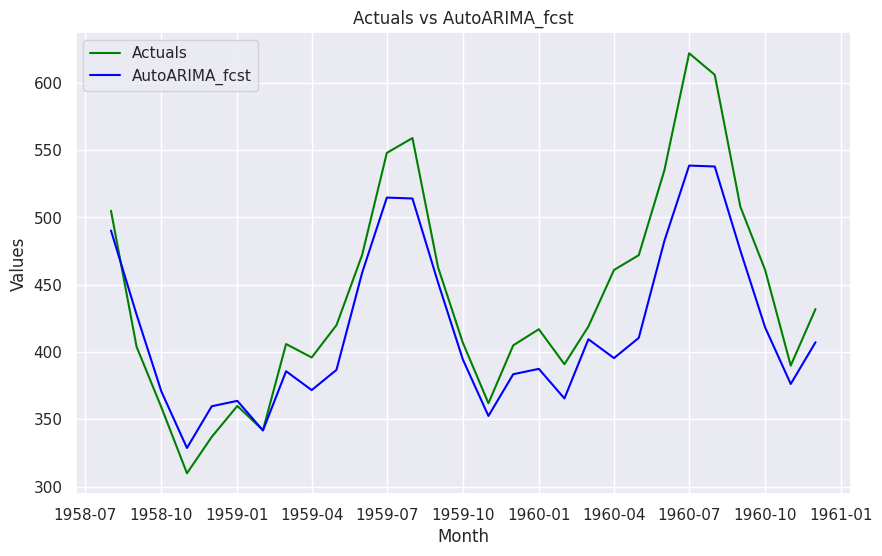

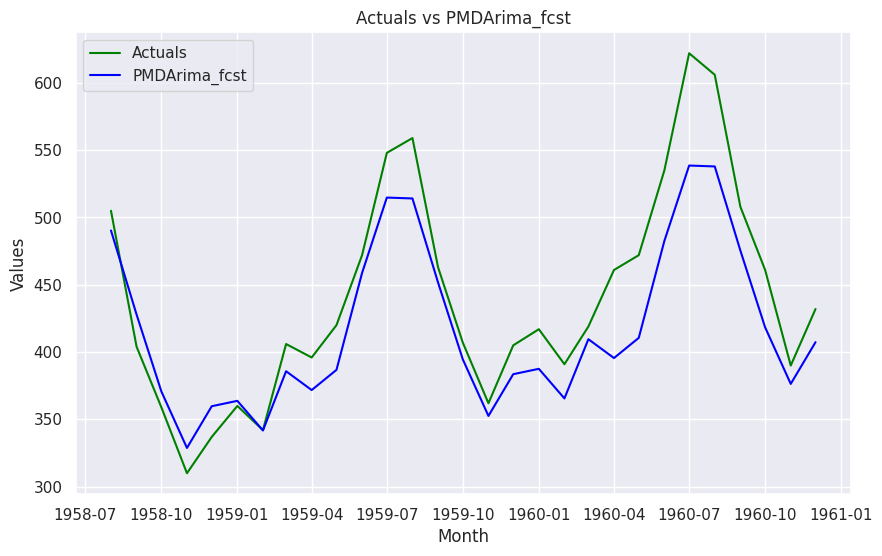

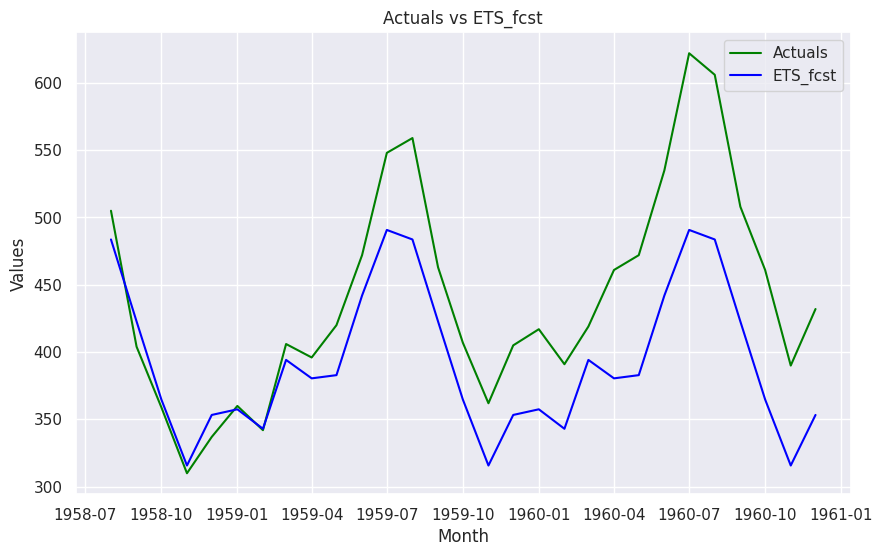

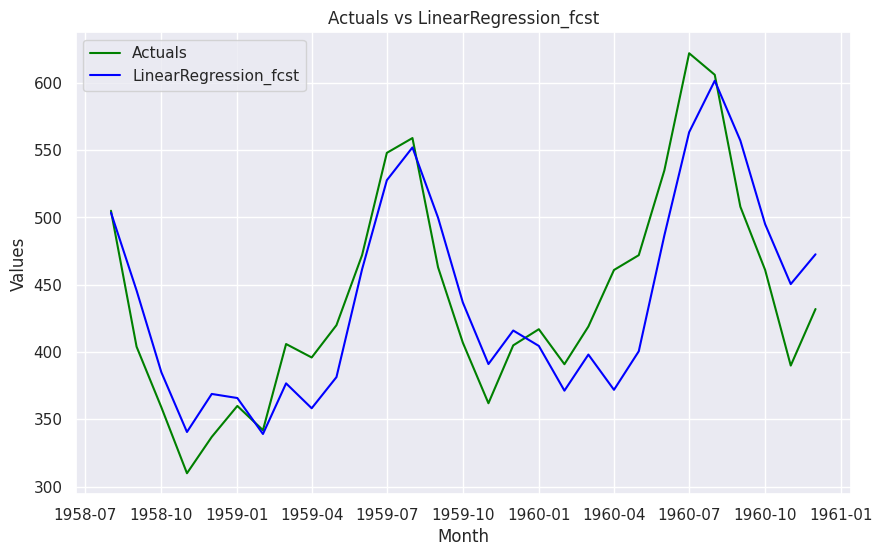

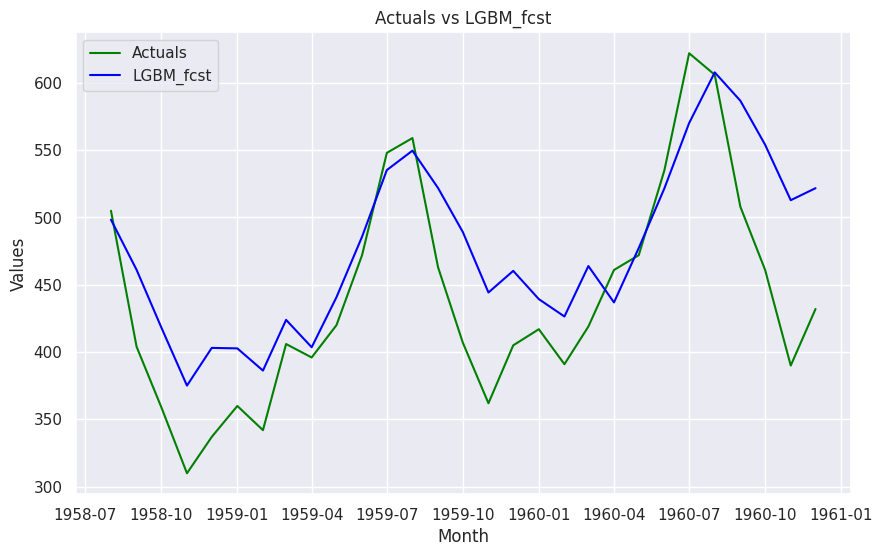

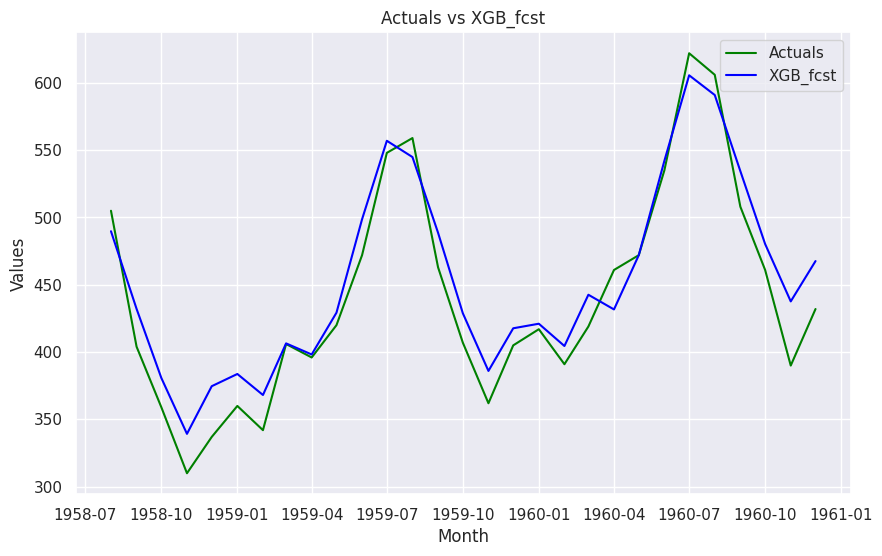

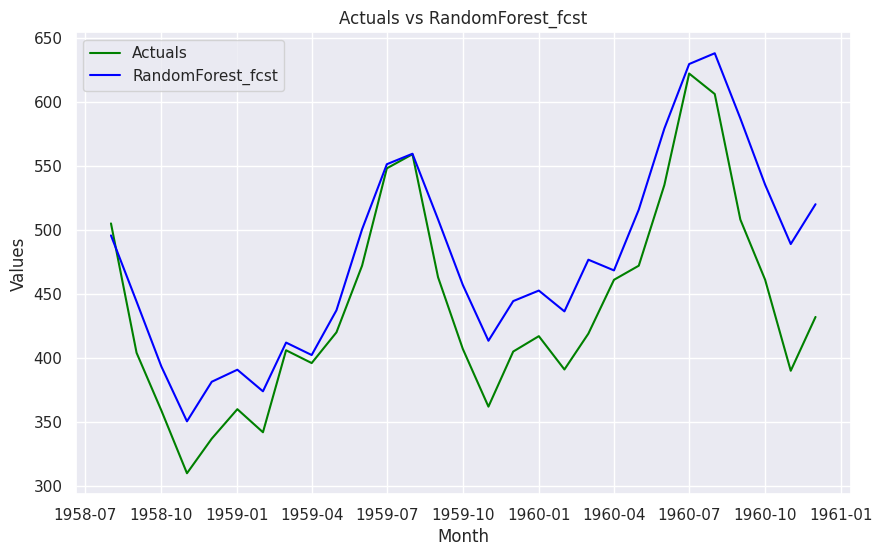

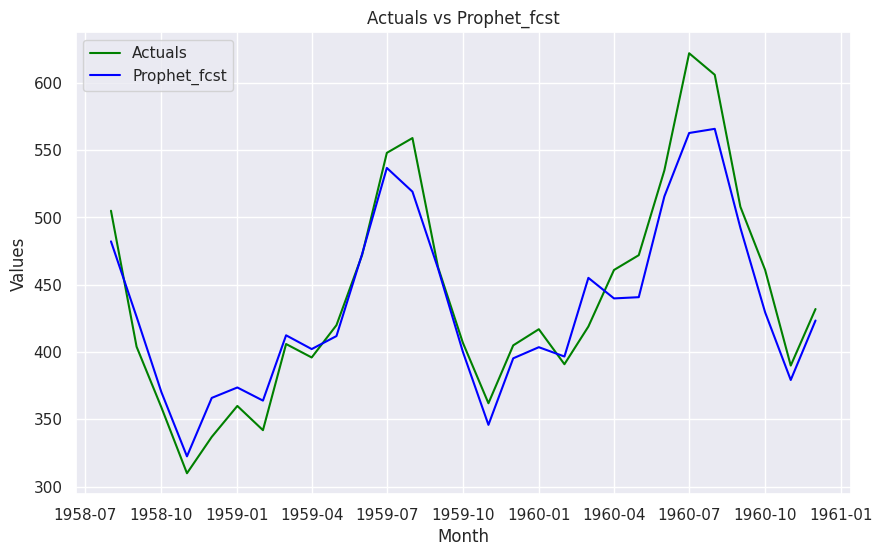

In [15]:
for col in fcst_result.columns[1:]:
    plt.figure(figsize=(10, 6))
    plt.plot(fcst_result.index, fcst_result['#Passengers'], label='Actuals', color='green')
    plt.plot(fcst_result.index, fcst_result[col], label=col, color='blue')
    plt.title(f'Actuals vs {col}')
    plt.xlabel('Month')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

From the error metrics for this dataset we can see that:

- Random Forecast Regression gives the lowest value for all the metrics, including RMSE & MAPE. It outperforms the traditional Statistical Models, which is quite an interesting finding of this research.
- The Boosting algorithms — Light GBM and XGBoost Regression also give superior performance to the statistical models like
- Exponential Smoothing in terms of MAPE, RMSE, and MAE.

The performance of the MLforecast models like XGB and LGBM are also satisfactory in the sense that their accuracy metrics are in line with that of the statistical models.

#### Concluding Remarks
Whether Machine Learning Models can outperform statistical models for time series forecasting is a subject of ongoing debate. Both approaches demonstrate their own strengths and weaknesses. The model performance will be dependent on factors like characteristics of the data — seasonality, trend and residuals, the specific forecasting task, the model hyperparameters, computational resources, interpretability requirements and the trade-offs between simplicity and accuracy.

It is well known that statistical models are effective for capturing the linear trends, seasonal patterns, and autocorrelation present in time series data. Also machine learning models are popular due to their ability to capture complex non-linear relationships and patterns within data.

This research has well established that the machine learning models have a fair competitive chance against the established statistical models. Models like Random Forest, XGB, and LGBM have given quite satisfactory forecasts, and Random Forests have also outperformed AutoARIMA and ETS for this popular benchmark dataset.

While incorporating this model into your forecasting toolkit, it should be kept in mind that the input features to the models play a significant part, and this needs to be fine-tuned. And with efficient fine-tuning, it can be concluded that machine learning models can very well fit into the forecasting toolkit.